In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python scikit-image numpy pandas tqdm


In [36]:
import os
from pathlib import Path

BASE = Path("/content/drive/MyDrive/DLCV_HW5/Dataset")

AGE_CLASSES = [
    "Adults (40-65)",
    "Children (7-12)",
    "Pre-school (3-6)",
    "Seniors (65+)",
    "Teens (13-17)",
    "Young Adults (18-40)"
]


#**Grayscale feature functions**
These features analyze the gray-intensity of pencil/pen strokes, which reflect pressure, tremor, skill development, stability, and motor control — all crucial indicators for age.

Below is a list of each grayscale feature function, what it computes, and why it is important for your age-classification task.



---


**1. intensity_stats(img)**

What it computes

* Mean stroke darkness

* Standard deviation of stroke intensity

Why

* Younger children have weaker pressure → lighter lines

* Teens/adults often write/draw with stronger pressure → darker strokes

Seniors may show:

* Lighter strokes due to reduced muscle force
* or varying intensity due to tremor

This captures pressure control and muscle strength.


---



**2. local_contrast(img)**
What it computes

* Local contrast between each pixel and a surrounding window (7×7)

* Mean contrast

* Std contrast

Why

High contrast means:
* usually means sharp, strong strokes

Low contrast means:

* weak motor control (kids)

* tremor-blurred strokes (seniors)

* soft pencils or uneven pressure

Captures clarity of strokes and precision.



---


**3. edge_energy(img)**

What it computes

* Gradient magnitude using Sobel filter

* Measures how sharp the edges of strokes are

Why

* Younger children have thicker and fuzzier edges

* Adults have clean, sharp cuts

* Seniors may have shaky or jagged edges

This feature quantifies edge sharpness and control of pencil movement.



---

**4. laplacian_var(img)**
What it computes

* The variance of the Laplacian (second derivative)

Why

* High Laplacian variance = lots of tiny fluctuations → micro-tremor

Good for distinguishing:

* Calm adult strokes (low)

* Older adults with tremor (high)

* Kids with unsteady lines (medium-high)

This captures very fine motor stability.


---

**5. gabor_features(img)**

What it computes

* Gabor filters at 4 directions: 0°, 45°, 90°, 135°

* For each: mean & std → 8 features total

Why

Gabor filters capture:

* Texture

* Shading

* Tremor frequency

* Pencil softness

* Directional patterns in strokes

Excellent for detecting texture and repetitive tremor patterns.

---
**6. intensity_histogram(img)**

What it computes

* 32-bin histogram of grayscale values (0–1)

Why

This describes the global pressure distribution:

* Kids → more bright pixels (lighter strokes)

* Adults → more dark pixels (firmer strokes)

* Seniors → bimodal distribution (light base + tremor artifacts)

This captures overall drawing style and pressure habits.

In [37]:
import cv2
import numpy as np

def load_gray(path):
    img = cv2.imread(path, 0).astype(np.float32)
    img = img / 255.0  # normalize
    return img


In [38]:
def intensity_stats(img):
    vals = img[img < 0.9]  # ignore background (~white)
    if len(vals) == 0:
        return (0,0)
    return vals.mean(), vals.std()


In [39]:
def local_contrast(img, ksize=7):
    mean = cv2.blur(img, (ksize,ksize))
    contrast = np.abs(img - mean)
    return contrast.mean(), contrast.std()

In [40]:
def edge_energy(img):
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(sobelx**2 + sobely**2)
    return mag.mean(), mag.std()


In [41]:

def laplacian_var(img):
    lap = cv2.Laplacian(img, cv2.CV_32F)
    return lap.var()


In [42]:
def gabor_features(img):
    feats = []
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for theta in thetas:
        kernel = cv2.getGaborKernel((9,9), 2.0, theta, 5.0, 0.5, 0, ktype=cv2.CV_32F)
        f = cv2.filter2D(img, -1, kernel)
        feats.append(f.mean())
        feats.append(f.std())
    return feats  # 8 numbers


In [43]:

def intensity_histogram(img, bins=32):
    hist, _ = np.histogram(img, bins=bins, range=(0,1))
    hist = hist / (hist.sum() + 1e-8)
    return hist



#**Binary & skeleton geometry functions**

These features analyze stroke shape, geometry, and motion path, which relate to the writer’s motor control and drawing style.

---

**1. soft_binarize(img)**

What it does

Creates a soft threshold mask for skeletonization, without losing grayscale information.

Why

You need a skeleton (1-pixel wide line) to compute geometric shape features.

---

**2. skeletonize(bw)**

What it does

Turns the stroke into a thin, 1-pixel curve.

Why

Geometry calculations (curvature, orientation, stroke segments) require a skeleton.

---

**3. curvature_features(skel)**

Computes

* Mean curvature of skeleton

* Variance of curvature

Why

* Kids: high curvature variance, chaotic lines

* Teens/adults: smooth, stable curves

* Seniors: jerky, tremor-curvature

This captures smoothness of line movement.

---
**4. stroke_width_features(bw)**

Computes

* Mean stroke width

* Variance of stroke width

Why

* Children: very inconsistent stroke widths

* Adults: consistent widths (controlled)

* Seniors: variations due to tremor or pressure loss

This tells how steady a person draws.

---
**5. orientation_histogram(skel)**

Computes

* Histogram of stroke direction (8 bins).

Why

* Adults draw more directionally consistent shapes

* Kids/Seniors produce lots of random direction noise

Shows orientation control of lines.

---

**6. shakiness_feature(skel)**

Computes

* High-frequency angle changes

Why

* Seniors often show micro-tremor (↑)

* Kids show erratic motions (↑)

* Adults are steady (↓)

This is a tremor stability indicator.

---

**7. jerk_feature(skel)**

Computes

* Derivative of curvature (change in curvature)

Why

Jerk = sudden changes in motion path

* Kids: high jerk

* Adults: low jerk

* Seniors: moderate jerk with tremor

Shows fluidity of motion.

---

**8. fractal_dimension(bw)**

Computes

* Complexity of the pattern at multiple scales

Why

* Kids: messy high complexity

* Adults: controlled low complexity

* Seniors: fractal-like patterns due to instability

Measures complexity of the line structure.

---

**9. count_segments(bw)**

Computes

* Number of connected components

Why

More segments = more broken/stopping strokes

* Kids stop often

* Adults write in continuous strokes

* Seniors may unintentionally break strokes

Shows continuity & rhythm of drawing.


In [44]:
def soft_binarize(img, thr=0.75):
    return (img < thr).astype(np.uint8)


In [45]:

def curvature_features(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return (0,0)
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    curvature = np.abs(np.diff(angles))
    return curvature.mean(), curvature.var()


In [46]:
def stroke_width_features(bw_img):
    dist = distance_transform_edt(bw_img)
    widths = dist[bw_img > 0] * 2
    if len(widths)==0:
        return (0,0)
    return widths.mean(), widths.var()



In [47]:
def orientation_histogram(skel, bins=8):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return np.zeros(bins)
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    hist, _ = np.histogram(angles, bins=bins, range=(-np.pi, np.pi), density=True)
    return hist


In [48]:
def shakiness_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10: return 0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    high_freq = np.abs(np.diff(angles))
    return high_freq.mean()



In [49]:
def jerk_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10: return 0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    jerk = np.abs(np.diff(np.diff(angles)))
    return jerk.mean()

In [50]:
def fractal_dimension(Z):
    assert(len(Z.shape) == 2)
    Z = Z > 0
    sizes = 2 ** np.arange(1, 6)
    counts = []
    for size in sizes:
        S = cv2.resize(Z.astype(np.uint8), (size, size), interpolation=cv2.INTER_NEAREST)
        counts.append(np.sum(S > 0))
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return coeffs[0]

In [51]:


def count_segments(bw_img):
    num_labels, labels = cv2.connectedComponents(bw_img.astype(np.uint8))
    return num_labels - 1



feature extractor (grayscale + geometry)

In [52]:
def extract_all_features(img_path):

    #  Load grayscale
    img = load_gray(img_path)

    # Grayscale features
    inten_mean, inten_std = intensity_stats(img)
    cont_mean, cont_std = local_contrast(img)
    edge_mean, edge_std = edge_energy(img)
    lap_var = laplacian_var(img)
    gabor = gabor_features(img)
    hist32 = intensity_histogram(img)

    #  Geometry features
    bw = soft_binarize(img)
    skel = skeletonize(bw > 0).astype(np.uint8)

    curv_mean, curv_var = curvature_features(skel)
    sw_mean, sw_var = stroke_width_features(bw)
    orient = orientation_histogram(skel)
    shake = shakiness_feature(skel)
    jerk  = jerk_feature(skel)
    frac  = fractal_dimension(bw)
    segs  = count_segments(bw)

    # Combine
    features = {
        "inten_mean": inten_mean,
        "inten_std": inten_std,
        "contrast_mean": cont_mean,
        "contrast_std": cont_std,
        "edge_mean": edge_mean,
        "edge_std": edge_std,
        "lap_var": lap_var,
        "curvature_mean": curv_mean,
        "curvature_var": curv_var,
        "stroke_width_mean": sw_mean,
        "stroke_width_var": sw_var,
        "shakiness": shake,
        "jerk": jerk,
        "fractal_dim": frac,
        "segments": segs,
    }

    # gabor
    for i,v in enumerate(gabor):
        features[f"gabor_{i}"] = v

    # orientation
    for i,v in enumerate(orient):
        features[f"orient_bin_{i}"] = v

    # grayscale histogram
    for i,v in enumerate(hist32):
        features[f"hist_bin_{i}"] = v

    return features



 Extraction for train/val/test

In [53]:
def extract_features_for_split(age_class, split):
    image_dir = BASE / age_class / split
    rows = []

    for img_name in tqdm(os.listdir(image_dir), desc=f"{age_class}-{split}"):
        img_path = image_dir / img_name

        feats = extract_all_features(str(img_path))
        feats["img_path"] = str(img_path)
        feats["age_class"] = age_class

        rows.append(feats)

    df = pd.DataFrame(rows)
    return df

Run ALL extraction

In [54]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm

import cv2
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt

all_dfs = []

for age in AGE_CLASSES:
    for split in ["train", "val", "test"]:
        df = extract_features_for_split(age, split)

        out_path = BASE / age / f"{split}_features.csv"
        df.to_csv(out_path, index=False)

        all_dfs.append(df)

# Combine into master CSV
master = pd.concat(all_dfs, ignore_index=True)
master.to_csv(BASE / "master_features.csv", index=False)

print("DONE! All feature CSVs saved.")

Adults (40-65)-train:   0%|          | 0/676 [00:00<?, ?it/s]/tmp/ipython-input-745050186.py:9: RuntimeWarning: divide by zero encountered in log
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
Young Adults (18-40)-test: 100%|██████████| 77/77 [02:44<00:00,  2.14s/it]


DONE! All feature CSVs saved.


# **Line plotting** to see if there is actually some patterns

In [55]:
!pip install scikit-learn matplotlib pandas numpy


Loaded: (3672, 65)
After dropna, rows: 283
PCA explained variance: [0.4103831  0.18683558 0.13982201]


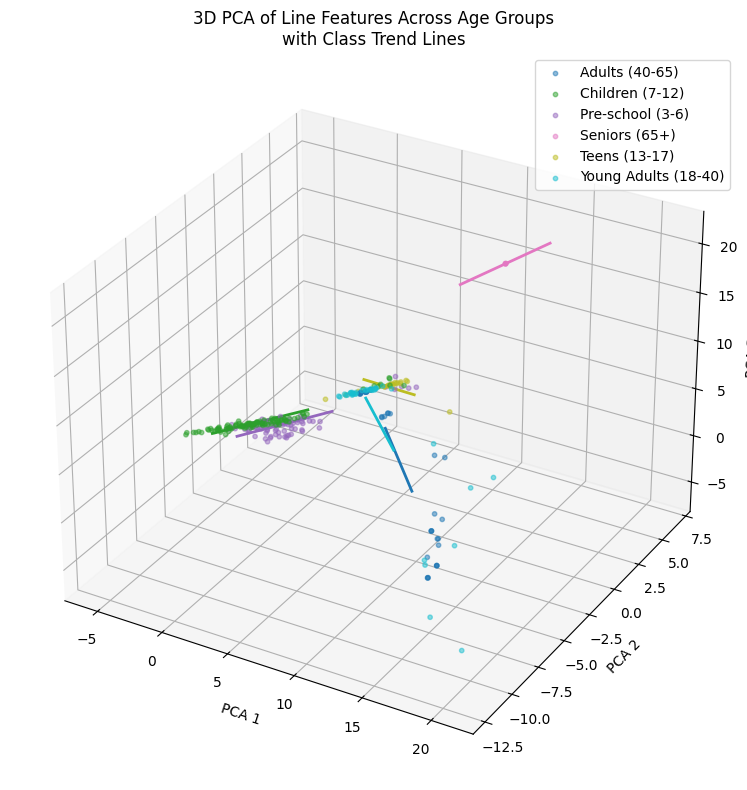

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

MASTER = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features.csv"
df = pd.read_csv(MASTER)

print("Loaded:", df.shape)

# non-feature columns
non_feature_cols = ["img_path", "age_class"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

#clean NaN / inf before PCA
feat_df = df[feature_cols].copy()
feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
feat_df_clean = feat_df.dropna(axis=0)

valid_idx = feat_df_clean.index
y = df.loc[valid_idx, "age_class"].values

print("After dropna, rows:", feat_df_clean.shape[0])

X = feat_df_clean.values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA → 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("PCA explained variance:", pca.explained_variance_ratio_)

# 3D Plot with class trend lines

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

age_groups = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(age_groups)))

for label, color in zip(age_groups, colors):
    mask = (y == label)
    pts = X_pca[mask]

    # scatter points
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        pts[:, 2],
        s=10,
        alpha=0.5,
        color=color,
        label=label
    )

    if pts.shape[0] > 2:
        # centroid in 3D
        center = pts.mean(axis=0)

        # 3D covariance + eigenvectors
        cov = np.cov(pts.T)
        eigvals, eigvecs = np.linalg.eig(cov)
        main_vec = eigvecs[:, np.argmax(eigvals)]  # 3D direction

        # parametric line: center ± t * main_vec
        t = np.linspace(-3, 3, 20)  # adjust length as needed
        line_x = center[0] + t * main_vec[0]
        line_y = center[1] + t * main_vec[1]
        line_z = center[2] + t * main_vec[2]

        ax.plot(line_x, line_y, line_z, color=color, linewidth=2)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA of Line Features Across Age Groups\nwith Class Trend Lines")

ax.legend()
plt.tight_layout()
plt.show()


In [57]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from skimage.morphology import skeletonize

# Path to your existing master CSV
BASE = Path("/content/drive/MyDrive/DLCV_HW5/Dataset")
MASTER = BASE / "master_features.csv"

df = pd.read_csv(MASTER)
print("Loaded master:", df.shape)

# Helper: load grayscale and normalize
def load_gray(path):
    img = cv2.imread(path, 0)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = img.astype(np.float32) / 255.0
    return img

# Helper: binarize (same style as your pipeline)
def soft_binarize(img, thr=0.75):
    return (img < thr).astype(np.uint8)

# Helper: skeleton topology features
def skeleton_topology_features(skel):
    sk = (skel > 0).astype(np.uint8)

    kernel = np.ones((3, 3), dtype=np.uint8)
    neighbor_count = cv2.filter2D(sk, -1, kernel) - sk

    mask = sk > 0
    deg = neighbor_count[mask]

    total_points = int(mask.sum())
    endpoints = int((deg == 1).sum())
    junctions = int((deg >= 3).sum())

    feats = {
        "skel_points": float(total_points),
        "skel_endpoints": float(endpoints),
        "skel_junctions": float(junctions),
        "skel_endpoints_ratio": endpoints / (total_points + 1e-6),
        "skel_junctions_ratio": junctions / (total_points + 1e-6),
    }
    return feats

# Helper: orientation histogram on skeleton
def orientation_histogram(skel, bins=8):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return np.zeros(bins, dtype=np.float32)
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:, 0], diffs[:, 1])
    hist, _ = np.histogram(angles, bins=bins, range=(-np.pi, np.pi), density=True)
    return hist

# We will compute new features for each row
skel_points_list = []
skel_endpoints_list = []
skel_junctions_list = []
skel_endpoints_ratio_list = []
skel_junctions_ratio_list = []
orient_entropy_list = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting features"):
    img_path = row["img_path"]
    img = load_gray(img_path)
    bw = soft_binarize(img)
    skel = skeletonize(bw > 0).astype(np.uint8)

    topo = skeleton_topology_features(skel)
    hist = orientation_histogram(skel, bins=8)

    if hist.sum() > 0:
        p = hist / (hist.sum() + 1e-8)
    else:
        p = hist + 1e-8
    orient_entropy = -np.sum(p * np.log(p + 1e-8))

    skel_points_list.append(topo["skel_points"])
    skel_endpoints_list.append(topo["skel_endpoints"])
    skel_junctions_list.append(topo["skel_junctions"])
    skel_endpoints_ratio_list.append(topo["skel_endpoints_ratio"])
    skel_junctions_ratio_list.append(topo["skel_junctions_ratio"])
    orient_entropy_list.append(float(orient_entropy))

# Add new columns to the dataframe
df["skel_points"] = skel_points_list
df["skel_endpoints"] = skel_endpoints_list
df["skel_junctions"] = skel_junctions_list
df["skel_endpoints_ratio"] = skel_endpoints_ratio_list
df["skel_junctions_ratio"] = skel_junctions_ratio_list
df["orient_entropy"] = orient_entropy_list

# Save back (you can change the name if you want a backup)
OUT_MASTER = BASE / "master_features_augmented.csv"
df.to_csv(OUT_MASTER, index=False)
print("Saved augmented master:", OUT_MASTER, "with shape:", df.shape)


Loaded master: (3672, 65)


Augmenting features: 100%|██████████| 3672/3672 [21:00<00:00,  2.91it/s]


Saved augmented master: /content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv with shape: (3672, 71)


In [4]:
import pandas as pd

path = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"

df = pd.read_csv(path)

# Remove the column
if "fractal_dim" in df.columns:
    df = df.drop(columns=["fractal_dim"])
    print("Removed column: fractal_dim")
else:
    print("Column fractal_dim not found.")

# Save back (overwrite)
df.to_csv(path, index=False)

print("Saved cleaned CSV back to the same file.")
print("New shape:", df.shape)


Removed column: fractal_dim
Saved cleaned CSV back to the same file.
New shape: (3672, 70)
